# Binding energy

> Graph of average binding energy per nucleon against nucleon number.

This is based on the version at Wikipedia:

![title](bindingenergy/bindingenergy.png)

That graph has been put into the public domain by its author, Fastfission (applies worldwide).  It was generated using the data [here](https://web.archive.org/web/20060309210852/http://www.einstein-online.info/en/spotlights/binding_energy/binding_energy/index.txt) (archived), and the original set of data used to generate the graph is available [here](https://commons.wikimedia.org/wiki/File_talk:Binding_energy_curve_-_common_isotopes.svg).

It is slightly unclear how the "common isotopes" were selected (there is a comment on the talk page to this effect), and the data used were calculated for [Einstein Online](http://www.einstein-online.info) using data from the Atomic Mass Data Center in July 2005.

I sourced some new data (AME2016) from the Atomic Mass Data Center as the ASCII file [mass16.txt](https://www-nds.iaea.org/amdc/ame2016/mass16.txt) of atomic masses.  This file is dated Mar-2017, and was published in:
- "The Ame2016 atomic mass evaluation (I)"   by W.J.Huang, G.Audi, M.Wang, F.G.Kondev, S.Naimi and X.Xu, Chinese Physics C41 030002, March 2017.
- "The Ame2016 atomic mass evaluation (II)"  by M.Wang, G.Audi, F.G.Kondev, W.J.Huang, S.Naimi and X.Xu, Chinese Physics C41 030003, March 2017

To get the data into a plottable form (removing the file header, removing 0 at start of the record for each nucleon number, removing codes to ensure awk recognized the fields correctly, removing non-experimental estimated values with \#), the following bash commands were used.

```
cat mass16.txt | tail -3436 | sed -r 's/^0|(\+|-)n[0-9]?p|(\+|-)?[0-9]?(p|n)+|x|(\+|-)?p[0-9]?n|(\+|-)a|2p-n|\+|p-2n|\+t|--|ep|IT| - //g' | awk '{ print $2, $3, $4, $5, $8 }' | grep -v --regexp=#  > data.dat
```

The data for binding energy per nucleon ($y$-axis in keV) against nucleon number ($x$-axis) were plotted on ```gnuplot``` using 
```
plot 'data.dat' u 3:5
replot 'wikidata.dat' u 3:($2*1000)
```

![title](bindingenergy/alldata.png)

The "common isotopes" from the Wikipedia graph, unsurprisingly, are the ones with a high binding energy per nucleon.  Now we want to limit the data to "common isotopes" to produce a graph more like the standard graph (e.g. on p. 41 of *Nuclear Physics: Principles and Applications*, John Lilley).  There are two ways we could do this:
- relative abundance
- half life
Clearly the two are somewhat related (though abundance also depends on how readily the element is nucleosynthesized inside stars).  I choose half life.

Half life data are in the [Nubase2016](https://www-nds.iaea.org/amdc/ame2016/nubase2016.txt) file.  First of all, that file needs a bit of massaging.  Let's start with the stable isotopes only, and have the first columns as (3 digit) $A$ and $Z$:
```
grep stbl nubase2016.txt | sed -r 's/([0-9][0-9][0-9])[0-9]/\1/g' | awk '{print $1, $2, $3}' > stables.dat
```

Now let's modify the order of columns in ```data.dat``` to give us $A$, $Z$, $N$ (rather than $N$, $Z$, $A$):
```
cat mass16.txt | tail -3436 | sed -r 's/^0|(\+|-)n[0-9]?p|(\+|-)?[0-9]?(p|n)+|x|(\+|-)?p[0-9]?n|(\+|-)a|2p-n|\+|p-2n|\+t|--|ep|IT| - //g'| awk '{ print $4, $3, $2, $5, $8 }' | grep -v --regexp=#  > data.dat
```

Now it would be good to change the 1st three columns in ```data.dat``` to give us 3 digits, to match the ```stables.dat``` file
```
sed -i -r -e 's/^([0-9]) /00\1 /g' -e 's/^([0-9][0-9]) /0\1 /g' -e 's///g' -e 's/ ([0-9]) ([0-9]) / 00\1 00\2 /g' -e 's/ ([0-9][0-9]) ([0-9]) / 0\1 00\2 /g' -e 's/ ([0-9]) ([0-9][0-9]) / 00\1 0\2 /g' -e 's/ ([0-9][0-9]) ([0-9][0-9]) / 0\1 0\2 /g' -e 's/ ([0-9][0-9]) / 0\1 /g' data.dat
```

Now a script is needed to extract $A$ and $Z$ for each line of ```stables.dat```, find the relevant nuclide line in ```data.dat``` and spit it into a new date file, ```stablesdata.dat```, which is a subset of the data.
```
#!/bin/bash
#
# Andrew C. Norman
# Radley College
# 2018-03-28
# 
# Extracts the data for the stable elements only to stablesdata.dat
# Usage: ./extractstables.sh

echo "# stable nuclide data (a subset of 'data.dat') > stablesdata.dat

cat stables.dat | while read LINE
do
# put A and Z for that nuclide into variables
A=$(echo "$LINE" | cut --delimiter=" " -f 1)
Z=$(echo "$LINE" | cut --delimiter=" " -f 2)
# now find the data for stable nuclide and put it into data.dat
grep -E "^$A $Z" data.dat >> stablesdata.dat
done

```

The resulting plot on gnuplot shows just the stable nuclides
```
plot 'stablesdata.dat' u 1:5 w l ls 2 
replot 'stablesdata.dat' u 1:5 w p ls 1
set term png    
set output 'stablesonly.png'
replot
set term x11
set output
```

![title](bindingenergy/stablesonly.png)

This looks a lot closer to what we are wanting, but the range of $A$ is a bit small: the Wikipedia graph goes up to $^{238}_{92}\mathrm{U}$. The next step is to add nuclides with very long half lives.  After a bit of playing around, including half lives measured in My is enough to include both $^{238}_{92}\mathrm{U}$ ($T_{\frac{1}{2}}=4.468~\mathrm{Gy}$) and $^{235}_{92}\mathrm{U}$ ($T_{\frac{1}{2}}=704~\mathrm{My}$).
```
grep -E ' (Yy|Zy|Ey|Py|Ty|Gy|My) ' nubase2016.txt | sed -r 's/([0-9][0-9][0-9])[0-9]/\1/g' | awk '{print $1, $2, $3, $7}' > longs.dat
```

The resulting plot looks spot on (the longs are in green):

![title](bindingenergy/stablesandlongs.png)

Advantages over the original wikipedia graph:
- Latest data for binding energies are used
- Unclear "commonness" criterion for inclusion replaced with a clearer "stability" rule ($T_{\frac{1}{2}}>1~\mathrm{My}$)
- No odd inclusions (e.g. $^3_1\mathrm{H}$, with a half life of just 12.32 years)
- Hopefully will now be able to plot with matplotlib, allowing use of $\LaTeX$, and therefore the nuclide notation in the right place

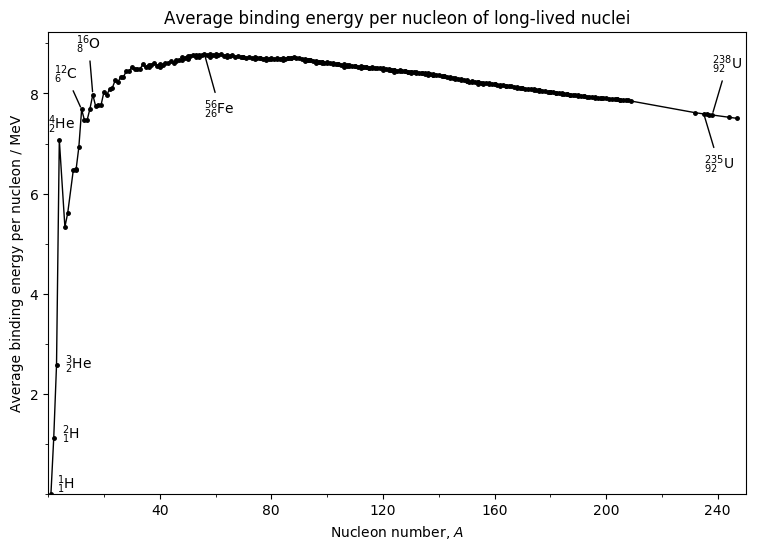

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

A, Z, N, B = np.loadtxt('./bindingenergy/alldata.dat', delimiter=' ', usecols=(0,1,2,4), \
                        unpack=True )

fig, ax = plt.subplots(figsize=(9, 6))
#fig = plt.figure(figsize=(8, 5))
#ax = fig.add_subplot(1,1,1)

plt.rcdefaults()
ax.plot(A, B/1000, 'ko-' , linewidth=1, markersize=2.5)

plt.ylim(ymin=0)
plt.xlim(0,250)

plt.title('Average binding energy per nucleon of long-lived nuclei')
plt.xlabel('Nucleon number, $A$')
plt.ylabel('Average binding energy per nucleon / MeV')

minorLocator = MultipleLocator(20)
# for the minor ticks, use no labels; default NullFormatter
ax.xaxis.set_minor_locator(minorLocator)
plt.xticks(np.arange(40, 280, step=40))

majorLocator = MultipleLocator(2)
minorLocator = MultipleLocator(1)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)
plt.yticks(np.arange(2, 9, step=2))

plt.annotate( '$^1_1\mathrm{H}$', xy=(3,0.1) )
plt.annotate( '$^2_1\mathrm{H}$', xy=(5,1.1) )
plt.annotate( '$^3_2\mathrm{He}$', xy=(6,2.5) )
plt.annotate( '$^4_2\mathrm{He}$', xy=(0,7.3) )
plt.annotate( '$^{12}_6\mathrm{C}$', xy=(12,7.68), \
             arrowprops=dict(arrowstyle='-'), xytext=(2,8.3) )
plt.annotate( '$^{16}_8\mathrm{O}$', xy=(16,7.98), \
             arrowprops=dict(arrowstyle='-'), xytext=(10,8.9) )
plt.annotate( '$^{56}_{26}\mathrm{Fe}$', xy=(56,8.79), \
             arrowprops=dict(arrowstyle='-'), xytext=(56,7.6) )
plt.annotate( '$^{235}_{92}\mathrm{U}$', xy=(235,7.59), \
             arrowprops=dict(arrowstyle='-'), xytext=(235,6.5) )
plt.annotate( '$^{238}_{92}\mathrm{U}$', xy=(238,7.57), \
             arrowprops=dict(arrowstyle='-'), xytext=(238,8.5) )

plt.show()


Important features to note about this graph:
- There is an initial sharp rise with $A$
- In mid range (near a nucleon number of 60) there is a broad maximum at about $8.6~\mathrm{MeV}$ per nucleon
- This is followed by a gradual decrease to about $7.6~\mathrm{MeV}$ per nucleon for the heaviest nuclei
- There are several sharp peaks in the light-nuclear region.
- When $A\gtrsim 120$, energy can be released by breaking the nucleus into two approximately equal fragments (*fission*)
- At the other end of the mass scale, energy can be released by combining two light nuclei to form a larger nuclei with a higher binding energy / $A$.  This is known as *fusion*

### The semi-empirical mass formula

The semi-empirical mass formula was originally developed in 1935 by C.F. Von Weizsäcker to fit known nuclear masses via a functions with few parameters, and thus enable useful estimates of the masses of unknown nuclei to be made.

In the SEMF, the total binding energy is expressed as the sum of five terms:
$$ B = a_{\mathrm{V}}A - a_{\mathrm{S}}A^{\frac{2}{3}} - a_{\mathrm{C}}\frac{Z^2}{A^{\frac{1}{3}}} - a_{\mathrm{a}}\frac{(N-Z)^{2}}{A} \pm \Delta, $$
where $a_{\mathrm{V}}, a_{\mathrm{S}}, a_{\mathrm{C}}, a_{\mathrm{a}}\text{ and }\Delta$ are constants obtained by fitting the formula to experimental data:
\begin{align}
a_{\mathrm{V}}&=15.56~\mathrm{MeV},\\
a_{\mathrm{S}}&=17.23~\mathrm{MeV},\\
a_{\mathrm{C}}&=0.7~\mathrm{MeV},\\
a_{\mathrm{a}}&=23.28~\mathrm{MeV}.\\
\end{align}

Let's try to use the SEMF for a "sketch graph" of the binding energy per nucleon against nucleon number graph.  First, we need $B/A$ in terms of just $A$.  We can easily get rid of $N=A-Z$, but we now need a form for $Z(A)$.  Since the SEMF is fitted from experimental data anyway, let's use gnuplot to make a crude fit from stable nuclei:
```
plot 'stablesdata.dat' u 1:2 
f(x) = a* x ** b 
fit f(x) 'stablesdata.dat' u 1:2 via a,b
replot f(x) 
```

![azfit.png](attachment:azfit.png)

That looks pretty decent.  gnuplot reports a convergent fit:
```
After 5 iterations the fit converged.
final sum of squares of residuals : 188.369
rel. change during last iteration : -2.18177e-13

degrees of freedom    (FIT_NDF)                        : 253
rms of residuals      (FIT_STDFIT) = sqrt(WSSR/ndf)    : 0.862868
variance of residuals (reduced chisquare) = WSSR/ndf   : 0.744542

Final set of parameters            Asymptotic Standard Error
=======================            ==========================

a               = 0.708817         +/- 0.01076      (1.519%)
b               = 0.892107         +/- 0.003039     (0.3407%)
```

So we have an empirical formula for $Z(A)$:
$$Z=0.71A^{0.892}$$.

Putting in $A=235$ for $^{235}_{92}\mathrm{U}$ gives $Z=93$.  Now let's make a sketch version of the graph.

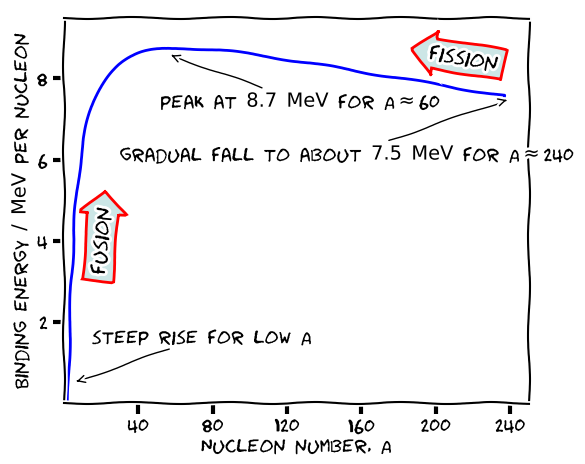

In [5]:
import numpy as np
import matplotlib.pyplot as plt

aV = 15.56 # definition from Lilley p. 41
aS = 17.23 # definition from Lilley p. 41
aC = 0.7 # definition from Lilley p. 41
aa= 23.28 # definition from Lilley p. 41
A=np.arange(1,238,1) # nucleon numbers
Z=0.71*A**0.892 # from our empirical Z(A) expression

# the SEMF

B= aV - aS * A ** (-1/3) - aC * ( Z**2 / A**(4/3) ) - aa * ((A-2*Z)**2/ A**2)

fig, ax = plt.subplots(figsize=(6, 5))

plt.xkcd()
ax.plot(A, B, 'b-' , linewidth=2)

plt.ylim(ymin=0)
plt.xlim(0,250)

plt.xlabel('Nucleon number, A')
plt.ylabel('Binding energy $/$ $\mathrm{MeV}$ per nucleon')


plt.xticks(np.arange(40, 280, step=40))
plt.yticks(np.arange(2, 9, step=2))

plt.annotate( 'steep rise for low A',
    xy=(5,0.5), arrowprops=dict(arrowstyle='->'), xytext=(15,1.5) )
plt.annotate( 'peak at $8.7$ $\mathrm{MeV}$ for A$\\approx$60',
    xy=(56,8.6), arrowprops=dict(arrowstyle='->'), xytext=(52,7.3) )
plt.annotate( 'gradual fall to about $7.5$ $\mathrm{MeV}$ for A$\\approx$240',
    xy=(240,7.5), arrowprops=dict(arrowstyle='->'), xytext=(30,6) )
bbox_props = dict(boxstyle="rarrow", fc=(0.8, 0.9, 0.9), ec="r", lw=2)
t = ax.text(20, 4, "fusion", ha="center", va="center", rotation=85,
            size=15,
            bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc=(0.8, 0.9, 0.9), ec="r", lw=2)
t = ax.text(215, 8.5, "fission", ha="center", va="center", rotation=-10,
            size=15,
            bbox=bbox_props)

plt.savefig("sketchbinding.pdf", bbox_inches='tight', pad_inches=0.1)

plt.show()